In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import minmax_scale

# force show all columns when displaying data in notebook
pd.set_option("display.max_columns", None)

# Get Data Function to concat all the cocoa trade years data into one data frame
def get_data(years,port):
    dflist = []
    pstr1 = "/home/cindynyoumsi/persistent/private-90d/"
    if port == 'exp':
        pstr2 = "exp.csv"
    elif port == 'imp':
        pstr2 = "imp.csv"
    else:
        pstr2 = str(port) + ".csv"
    # Read data and concat if more than one data set
    for year in years:
        path = pstr1 + str(year) + pstr2
        df_temp = pd.read_csv(path,na_values=["nan"])
        dflist.append(df_temp)
    dfunion = pd.concat(dflist, ignore_index=True)
    return dfunion

# Function to get years we are interested in a list to use for Get Data function
def year_list(start_year,interval):
    yearlist = []
    yearlist.append(start_year)
    for i in range(interval):
        start_year += 1
        yearlist.append(start_year)
    return yearlist

# Function to interpolate missing data
def interpolmissing(df):
    reporterdflist = [] 
    for i in range(len(df.Reporter.unique())):
            currentreporter = df.Reporter.unique()[i]
            dfcocoadatareporter= df[df['Reporter'] == currentreporter]
            if dfcocoadatareporter.shape[0] <= 2:
                continue
            dfcocoadatareporter = dfcocoadatareporter.assign(New_Trade_Value_1000USD = dfcocoadatareporter.Trade_Value_1000USD.interpolate(method='slinear'))
            dfcocoadatareporter = dfcocoadatareporter.assign(New_Quantity = dfcocoadatareporter.Quantity.interpolate(method='slinear'))
            reporterdflist.append(dfcocoadatareporter)
    dfunion = pd.concat(reporterdflist, ignore_index=True)
    return dfunion
      

I0819 134843.736 font_manager.py:1349] generated new fontManager


In [2]:
#. ------------- Data Import & Pre-processing --------------------------------------
# pd.set_option('display.max_rows', None)

# Creating years of interest list for data
years = year_list(1999,20)

# Getting all the import & Export cocoa trade data and Export cocoa derivative + chocolate trade data
expcocoadata = get_data(years,'exp')
impcocoadata = get_data(years,'imp')
chocexp = get_data(years,'chocexp')

# Selecting relevant columns only
cols = ["Reporter","TradeFlow","ProductCode","Year","Trade Value 1000USD","Quantity"]
choccols = ["Reporter","TradeFlow","Year","Trade Value 1000USD","Quantity"]
expcocoadata = expcocoadata[cols]
impcocoadata = impcocoadata[cols]
# chocexp = chocexp[choccols]

# Renaming columns 
expcocoadata = expcocoadata.rename(columns = {'Trade Value 1000USD': 'Trade_Value_1000USD'}, inplace = False)
impcocoadata = impcocoadata.rename(columns = {'Trade Value 1000USD': 'Trade_Value_1000USD'}, inplace = False)
# chocexp = chocexp.rename(columns = {'Trade Value 1000USD': 'Trade_Value_1000USD'}, inplace = False)

# Change Year int column to datetime
pd.to_datetime(expcocoadata.Year, format='%Y')
pd.to_datetime(impcocoadata.Year, format='%Y')
# pd.to_datetime(chocexp.Year, format='%Y')

#. ------------- Interpolating Missing Data for Year 2017 --------------------------------------

# Interpolate export and import data
expcocoadata = interpolmissing(expcocoadata)
impcocoadata = interpolmissing(impcocoadata)
# chocexp = interpolmissing(chocexp)


# ------------- Handling Cocoa Derivatives Data --------------------------------------
# Merge and sum trade value data and quantity data
expchocdflist = ['chocexp','chocexp1','chocexp2','chocexp3','chocexp4']
for filename in expchocdflist:
    chocdata = get_data(years,filename)
    choccols = ["Reporter","Year","Trade Value 1000USD","Quantity"]
    chocdata = chocdata[choccols]
    chocdata = chocdata.rename(columns = {'Trade Value 1000USD': 'Trade_Value_1000USD'}, inplace = False)
    pd.to_datetime(chocdata.Year, format='%Y')
    chocdata = interpolmissing(chocdata)
    chocexp = pd.merge(chocexp, chocdata, how = 'outer', on=['Reporter','Year'])


# sum all choc trade values and quantity
chocexp['Sum_Trade_Value_1000USD'] = chocexp.iloc[:,[11,15,19,23,27]].sum(axis = 1)
chocexp['Sum_Quantity'] = chocexp.iloc[:,[12,16,20,24,28]].sum(axis = 1)
finalchoccols = ["Reporter","TradeFlow","Year","Sum_Trade_Value_1000USD","Sum_Quantity"]
chocexp = chocexp[finalchoccols]

# print()
# print('chocexp')
# print(chocexp)
# print()


# Assessing null values after interpolation (comment out later)
# print("Export data missing values")
# print(expcocoadata.isna().sum())
# print(expcocoadata[expcocoadata.isna().any(axis=1)])
# print()
# print("Import data missing values")
# print(impcocoadata.isna().sum())
# print(impcocoadata[impcocoadata.isna().any(axis=1)])
# print()

# ------------- Add Country GDP data ---------------------------------------

country_gdp = pd.read_csv("/home/cindynyoumsi/persistent/private-90d/speccountrygdp.csv",na_values=["nan"])
# Export
exp_cocoadata_gdp = pd.merge(expcocoadata, country_gdp, on=['Reporter','Year'])
exp_cocoadata_gdp["Trade_Value_USD"] = exp_cocoadata_gdp['Trade_Value_1000USD']*1000
exp_cocoadata_gdp["cocoa_share_gdp"] = exp_cocoadata_gdp['Trade_Value_USD']/exp_cocoadata_gdp['GDP']
exp_cocoadata_gdp["gdp_percent"] = 1 - exp_cocoadata_gdp["cocoa_share_gdp"] 

#Import
imp_cocoadata_gdp = pd.merge(impcocoadata, country_gdp, on=['Reporter','Year'])
imp_cocoadata_gdp["Trade_Value_USD"] = imp_cocoadata_gdp['Trade_Value_1000USD']*1000
imp_cocoadata_gdp["cocoa_share_gdp"] = imp_cocoadata_gdp['Trade_Value_USD']/imp_cocoadata_gdp['GDP']
imp_cocoadata_gdp["gdp_percent"] = 1 - imp_cocoadata_gdp["cocoa_share_gdp"] 

#ChocExport
chocexp_gdp = pd.merge(chocexp, country_gdp, on=['Reporter','Year'])
chocexp_gdp["sum_of_trade_value_usd"] = chocexp_gdp['Sum_Trade_Value_1000USD']*1000
chocexp_gdp["cocoa_share_gdp"] = chocexp_gdp['sum_of_trade_value_usd']/chocexp_gdp['GDP']
chocexp_gdp["gdp_percent"] = 1 - chocexp_gdp["cocoa_share_gdp"]

# # Set Year column as index
# expcocoadata = expcocoadata.set_index('Year')
# impcocoadata = impcocoadata.set_index('Year')

# # Looking at missing values
# # Assessing null values (comment out later)
# print("Export data missing values")
# print(expcocoadata.isna().sum())
# print(expcocoadata[expcocoadata.isna().any(axis=1)])
# print()
# # Assessing null values (comment out later)
# print("Import data missing values")
# print(impcocoadata.isna().sum())
# print(impcocoadata[impcocoadata.isna().any(axis=1)])
# print()

In [15]:
# ------------------------------------ More Data Pre-Processing -----------------------------------

# Normalize Trade Value Data per country
expcocoadata["New_Trade_Value_1000USD_Scaled"] = expcocoadata['New_Trade_Value_1000USD'].groupby(expcocoadata['Reporter']).transform(lambda x: minmax_scale(x.astype(float)))
impcocoadata["New_Trade_Value_1000USD_Scaled"] = impcocoadata['New_Trade_Value_1000USD'].groupby(impcocoadata['Reporter']).transform(lambda x: minmax_scale(x.astype(float)))
chocexp["New_Trade_Value_1000USD_Scaled"] = chocexp['Sum_Trade_Value_1000USD'].groupby(chocexp['Reporter']).transform(lambda x: minmax_scale(x.astype(float)))

# Finding the top countries that make up 70% of cocoa and derivative exports or imports
    # step 1: Add a column that evaluates % of Exported GDP for that year and extra for new reporter renaming
    # Export
expcocoadata['yearsum'] = expcocoadata['New_Trade_Value_1000USD'].groupby(expcocoadata['Year']).transform("sum")
expcocoadata['qtyyearsum'] = expcocoadata['New_Quantity'].groupby(expcocoadata['Year']).transform("sum")
expcocoadata['percent_trade'] = expcocoadata['New_Trade_Value_1000USD']/expcocoadata['yearsum']
expcocoadata['New_Reporter'] = expcocoadata['Reporter']

    # Import
impcocoadata['yearsum'] = impcocoadata['New_Trade_Value_1000USD'].groupby(impcocoadata['Year']).transform("sum")
impcocoadata['qtyyearsum'] = impcocoadata['New_Quantity'].groupby(impcocoadata['Year']).transform("sum")
impcocoadata['percent_trade'] = impcocoadata['New_Trade_Value_1000USD']/impcocoadata['yearsum']
impcocoadata['New_Reporter'] = impcocoadata['Reporter']


    # ChocExport
chocexp['yearsum'] = chocexp['Sum_Trade_Value_1000USD'].groupby(chocexp['Year']).transform("sum")
chocexp['qtyyearsum'] = chocexp['Sum_Quantity'].groupby(chocexp['Year']).transform("sum")
chocexp['percent_trade'] = chocexp['Sum_Trade_Value_1000USD']/chocexp['yearsum']
chocexp['New_Reporter'] = chocexp['Reporter']

    # step 2: select countries per year with percenttrade > 0.07
    # Export
exphightradevals = expcocoadata[expcocoadata['percent_trade'] > 0.07] 
exphigh_country_list = exphightradevals['Reporter'].unique()
    # Import
imphightradevals = impcocoadata[impcocoadata['percent_trade'] > 0.07] 
imphigh_country_list = imphightradevals['Reporter'].unique()
    # ChocExport
choc_exphightradevals = chocexp[chocexp['percent_trade'] > 0.07] 
choc_exphigh_country_list = choc_exphightradevals['Reporter'].unique()  

    # Group countries with percenttrade <= 0.07 in OG dataframe
expcocoadata.loc[~expcocoadata.Reporter.isin(exphigh_country_list), 'New_Reporter'] = 'Other'
impcocoadata.loc[~impcocoadata.Reporter.isin(imphigh_country_list), 'New_Reporter'] = 'Other'
chocexp.loc[~chocexp.Reporter.isin(choc_exphigh_country_list), 'New_Reporter'] = 'Other'

# filter dataframe by relevant list of countries   
exphigh_vals_data = expcocoadata[expcocoadata.Reporter.isin(exphigh_country_list)]
imphigh_vals_data = impcocoadata[impcocoadata.Reporter.isin(imphigh_country_list)]
choc_exphigh_vals_data = chocexp[chocexp.Reporter.isin(choc_exphigh_country_list)]

             New_Reporter  percent_trade
0             Netherlands   1.381379e-01
1                 Germany   1.262770e-01
2          United Kingdom   6.221019e-02
3           United States   4.466611e-02
4                 Austria   2.180640e-02
...                   ...            ...
2806               Malawi   2.471839e-08
2807               Malawi   4.711260e-09
2808               Malawi   4.994456e-07
2809                Benin   2.141368e-08
2810  St. Kitts and Nevis   2.944538e-10

[2811 rows x 2 columns]



expcocoadata yearsum
         yearsum    qtyyearsum  Year  exp_year_sum_Scaled  \
0   2.402898e+06  2.058608e+09  1999             0.070905   
1   1.770612e+06  2.171399e+09  2000             0.000000   
2   2.032445e+06  5.033992e+09  2001             0.029362   
3   3.100441e+06  7.797308e+09  2002             0.149127   
4   3.656475e+06  3.335061e+09  2003             0.211481   
5   2.980852e+06  4.092417e+09  2004             0.135716   
6   7.316043e+06  4.965243e+09  2005             0.621865   
8   4.165101e+06  3.227579e+09  2006             0.268518   
9   4.574742e+06  2.554691e+09  2007             0.314455   
10  8.064026e+06  2.747478e+09  2009             0.705744   
11  7.974867e+06  2.849240e+09  2010             0.695745   
12  9.443639e+06  4.827571e+09  2011             0.860453   
13  1.005632e+07  3.791190e+09  2012             0.929159   
14  8.548010e+06  2.985987e+09  2013             0.760017   
15  9.345103e+06  3.268943e+09  2014             0.849403   
16

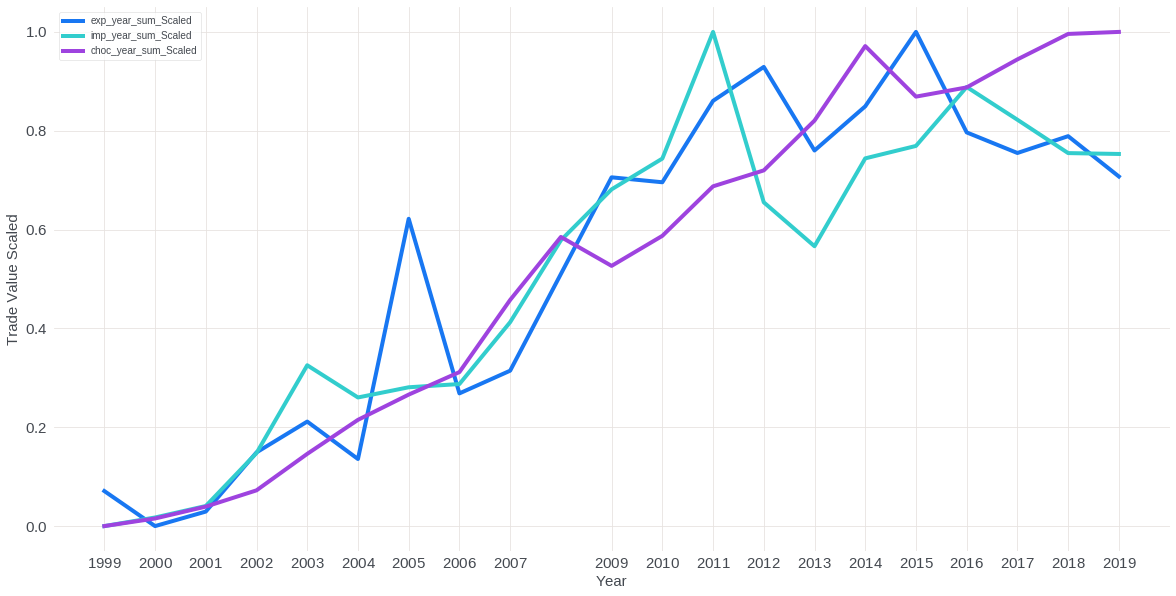

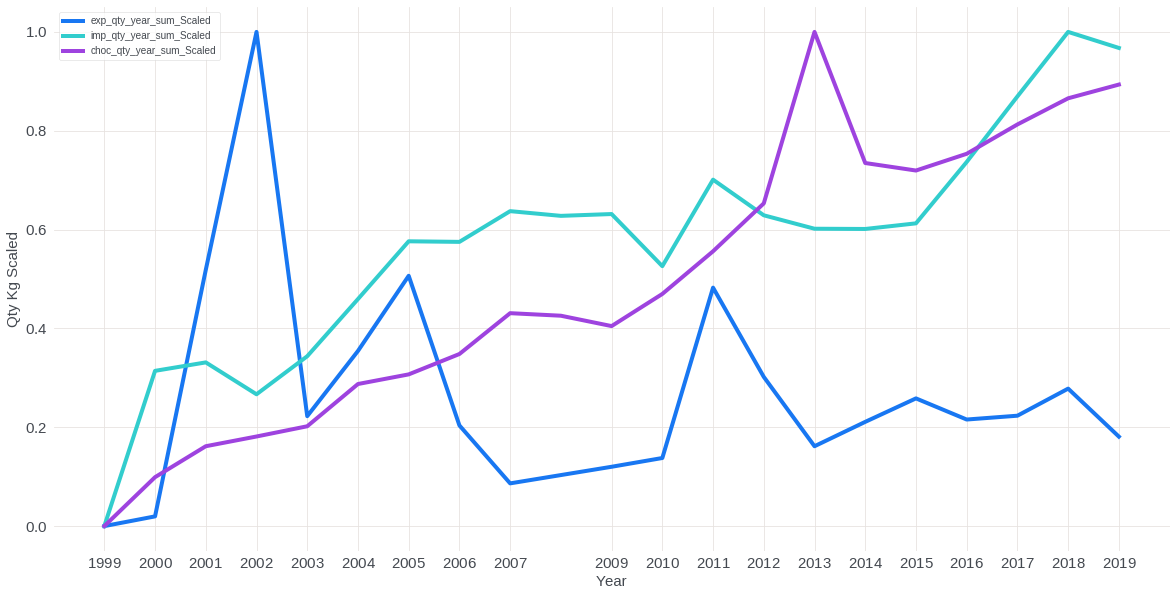

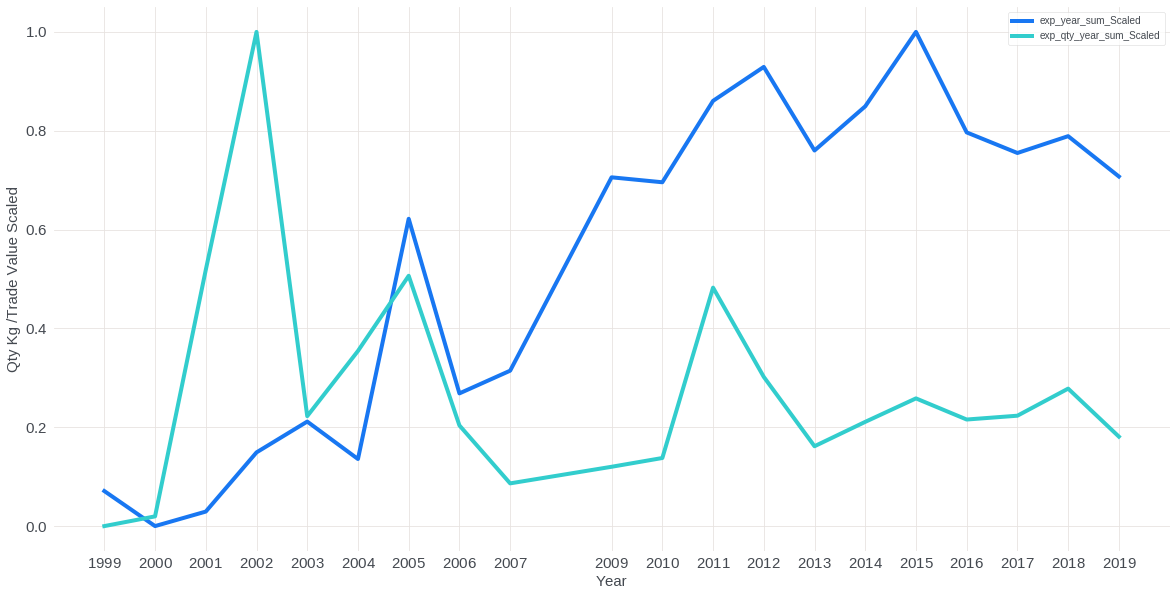

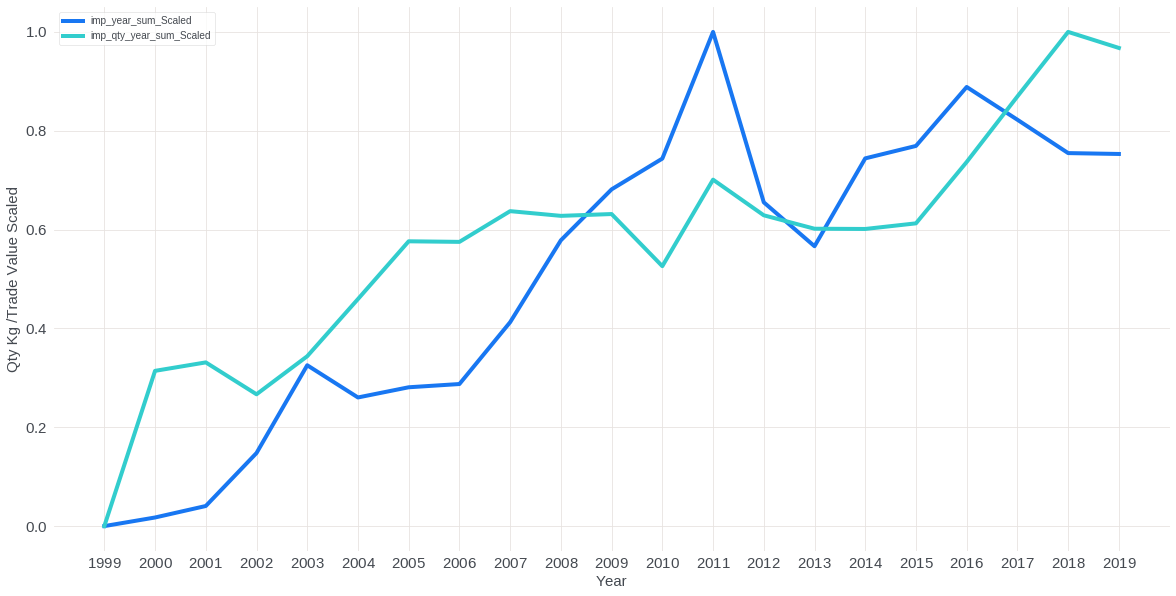

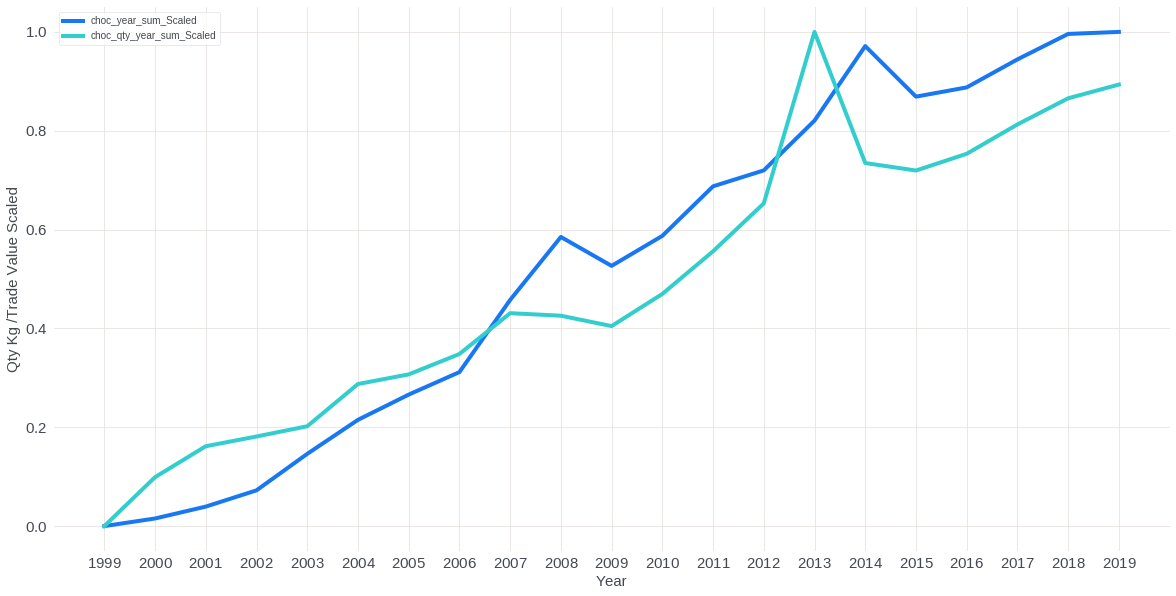

In [5]:
# Zooming in on year of shortage 

expcocoadata_years = expcocoadata[expcocoadata.Year.isin(years)]
expcocoadata_years = expcocoadata_years[['yearsum','qtyyearsum','Year']]
expcocoadata_years = expcocoadata_years.drop_duplicates()
expcocoadata_years["exp_year_sum_Scaled"] = expcocoadata_years['yearsum'].transform(lambda x: minmax_scale(x.astype(float)))
expcocoadata_years["exp_qty_year_sum_Scaled"] = expcocoadata_years['qtyyearsum'].transform(lambda x: minmax_scale(x.astype(float)))
expcocoadata_years['percent_change'] = ((expcocoadata_years['yearsum']/expcocoadata_years['yearsum'].shift(1, fill_value=1))-1)*100
expcocoadata_years['qty_percent_change'] = ((expcocoadata_years['qtyyearsum']/expcocoadata_years['qtyyearsum'].shift(1, fill_value=1))-1)*100
# print()
# print('expcocoadata shifted')
# print(expcocoadata_years['yearsum'].shift(1, fill_value=1))
# print()
print()
print('expcocoadata yearsum')
print(expcocoadata_years)
print()

impcocoadata_years = impcocoadata[impcocoadata.Year.isin(years)]
impcocoadata_years = impcocoadata_years[['yearsum','qtyyearsum','Year']]
impcocoadata_years = impcocoadata_years.drop_duplicates()
impcocoadata_years["imp_year_sum_Scaled"] = impcocoadata_years['yearsum'].transform(lambda x: minmax_scale(x.astype(float)))
impcocoadata_years["imp_qty_year_sum_Scaled"] = impcocoadata_years['qtyyearsum'].transform(lambda x: minmax_scale(x.astype(float)))
impcocoadata_years['percent_change'] = ((impcocoadata_years['yearsum']/impcocoadata_years['yearsum'].shift(1, fill_value=1))-1)*100
impcocoadata_years['qty_percent_change'] = ((impcocoadata_years['qtyyearsum']/impcocoadata_years['qtyyearsum'].shift(1, fill_value=1))-1)*100
print()
print('impcocoadata yearsum')
print(impcocoadata_years)
print()

chocexp_years = chocexp[chocexp.Year.isin(years)]
chocexp_years = chocexp_years[['yearsum','qtyyearsum','Year']]
chocexp_years = chocexp_years.drop_duplicates()
chocexp_years["choc_year_sum_Scaled"] = chocexp_years['yearsum'].transform(lambda x: minmax_scale(x.astype(float)))
chocexp_years["choc_qty_year_sum_Scaled"] = chocexp_years['qtyyearsum'].transform(lambda x: minmax_scale(x.astype(float)))
chocexp_years['percent_change'] = ((chocexp_years['yearsum']/chocexp_years['yearsum'].shift(1, fill_value=1))-1)*100
chocexp_years['qty_percent_change'] = ((chocexp_years['qtyyearsum']/chocexp_years['qtyyearsum'].shift(1, fill_value=1))-1)*100
print()
print('chocexp yearsum')
print(chocexp_years)
print()


# Plot Year Sum Scaled Values to see trends
ax = expcocoadata_years.plot(x = "Year", y = "exp_year_sum_Scaled", figsize=(20, 10))
impcocoadata_years.plot(ax = ax, x = "Year",y = 'imp_year_sum_Scaled')
chocexp_years.plot(ax = ax, x = "Year", y = 'choc_year_sum_Scaled')
# plt.legend(["cocoa Export", "Cocoa Import", "Choc Export"])
plt.xlabel("Year")
plt.ylabel("Trade Value Scaled")
plt.xticks(expcocoadata_years['Year'])
plt.show()
plt.close()

# Plot Qty Year Sum Scaled Values to see trends
ax = expcocoadata_years.plot(x = "Year", y = "exp_qty_year_sum_Scaled", figsize=(20, 10))
impcocoadata_years.plot(ax = ax, x = "Year",y = 'imp_qty_year_sum_Scaled')
chocexp_years.plot(ax = ax, x = "Year", y = 'choc_qty_year_sum_Scaled')
# plt.legend(["cocoa Qty Export", "Cocoa Qty Import", "Choc Qty Export"])
plt.xlabel("Year")
plt.ylabel("Qty Kg Scaled")
plt.xticks(expcocoadata_years['Year'])
plt.show()
plt.close()

# Plot Trade Value Against Qty Year Sum Scaled Values to see trends
ax = expcocoadata_years.plot(x = "Year", y = "exp_year_sum_Scaled",figsize=(20, 10))
expcocoadata_years.plot(ax = ax, x = "Year", y = "exp_qty_year_sum_Scaled")
plt.xlabel("Year")
plt.ylabel("Qty Kg /Trade Value Scaled")
plt.xticks(expcocoadata_years['Year'])
plt.show()
plt.close()

ax = impcocoadata_years.plot(x = "Year", y = "imp_year_sum_Scaled",figsize=(20, 10))
impcocoadata_years.plot(ax = ax, x = "Year", y = "imp_qty_year_sum_Scaled")
plt.xlabel("Year")
plt.ylabel("Qty Kg /Trade Value Scaled")
plt.xticks(impcocoadata_years['Year'])
plt.show()
plt.close()

ax = chocexp_years.plot(x = "Year", y = "choc_year_sum_Scaled",figsize=(20, 10))
chocexp_years.plot(ax = ax, x = "Year", y = "choc_qty_year_sum_Scaled")
plt.xlabel("Year")
plt.ylabel("Qty Kg /Trade Value Scaled")
plt.xticks(chocexp_years['Year'])
plt.show()
plt.close()

    Cocoa_Import_Trade_Value_USD  Cocoa_derivative_Export_Trade_Value_USD
0                   6.881510e+08                             1.160174e+09
1                   4.343632e+08                             9.540755e+08
2                   5.410669e+08                             1.003722e+09
3                   6.044974e+08                             1.123795e+09
4                   9.748704e+08                             1.380263e+09
5                   7.520421e+08                             1.543263e+09
6                   8.316384e+08                             1.808478e+09
7                   6.907819e+08                             1.898061e+09
8                   9.408314e+08                             2.311026e+09
9                   1.297984e+09                             2.751645e+09
10                  1.747822e+09                             2.545781e+09
11                  1.698950e+09                             2.508865e+09
12                  2.167652e+09      

<ipython-input-86-c292117a415e>:30: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



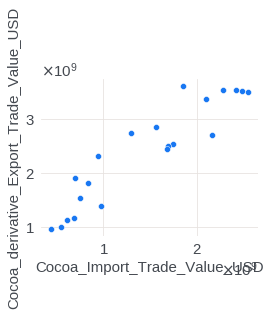

X_test
[[4.00611390e+08]
 [2.43632990e+08]
 [2.22211210e+08]
 [6.76090000e+08]
 [7.92129870e+08]
 [7.92129870e+08]
 [1.09632184e+09]
 [8.96390160e+08]
 [1.08877732e+09]
 [8.47376540e+08]
 [2.07155732e+09]
 [1.96776166e+09]
 [1.38050132e+09]
 [2.00815687e+09]
 [2.72975625e+09]
 [1.88621873e+09]
 [2.16170652e+09]
 [2.43719432e+09]
 [1.85196039e+09]]

X_train
[[6.88150960e+08]
 [4.34363200e+08]
 [5.41066890e+08]
 [6.04497350e+08]
 [9.74870450e+08]
 [7.52042080e+08]
 [8.31638440e+08]
 [6.90781930e+08]
 [9.40831420e+08]
 [1.29798416e+09]
 [1.74782225e+09]
 [1.69895033e+09]
 [2.16765212e+09]
 [1.67972227e+09]
 [1.56324453e+09]
 [1.85354117e+09]
 [2.09959682e+09]
 [2.54995025e+09]
 [2.48810362e+09]
 [2.42625700e+09]
 [2.28260933e+09]]

0.8591953041445158
y_pred
[[1.12561822e+09]
 [9.35938214e+08]
 [9.10053867e+08]
 [1.45848431e+09]
 [1.59869750e+09]
 [1.59869750e+09]
 [1.96625849e+09]
 [1.72467721e+09]
 [1.95714230e+09]
 [1.66545311e+09]
 [3.14465421e+09]
 [3.01923592e+09]
 [2.30963800e+09]
 

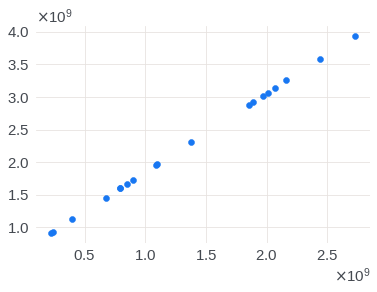

In [86]:

# importing linear regresshion and KDtree from assemble module and neighbors module
# from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KDTree
from sklearn import preprocessing, svm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression


# Finding the import country closest to Ghana if Ghana were to become an Import Country
# impdata = impcocoadata[impcocoadata['Year']==2019]
# imppdata = impcocoadata[["Trade_Value_USD","Year"]]
# tree = KDTree(imppdata)
# country = expcocoadata[(expcocoadata['Reporter'] == 'Ghana')&(expcocoadata['Year'] == 2019)]
# K = 2
# For finding K neighbors of Ghana 
# indices, distances = tree.query(country, K)

# Predicting what Ghana would export in Chocolate Value if it were like the Netherlands
impcocoanetherlands = impcocoadata[impcocoadata['Reporter']=='Netherlands']
impcocoanetherlands = impcocoanetherlands[['Year','New_Trade_Value_1000USD']]
chocexpnetherlands = chocexp[chocexp['Reporter']=='Netherlands']
chocexpnetherlands = chocexpnetherlands[['Year','Sum_Trade_Value_1000USD']]
netherlandsimpexp = pd.merge(impcocoanetherlands, chocexpnetherlands, how = 'outer', on=['Year'])
netherlandsimpexp["Cocoa_Import_Trade_Value_USD"] = netherlandsimpexp['New_Trade_Value_1000USD']*1000
netherlandsimpexp["Cocoa_derivative_Export_Trade_Value_USD"] = netherlandsimpexp['Sum_Trade_Value_1000USD']*1000
netherlandsimpexp = netherlandsimpexp[['Cocoa_Import_Trade_Value_USD','Cocoa_derivative_Export_Trade_Value_USD']]
print(netherlandsimpexp)
print()
Ghanadata = expcocoadata[(expcocoadata['Reporter'] == 'Ghana')]
Ghanadata['New_Trade_Value_USD'] = Ghanadata['New_Trade_Value_1000USD']*1000
Ghanadata = Ghanadata[['New_Trade_Value_USD']]
print(Ghanadata)

# use a simple linear regression to estimate cocoa derivative export given 1.85B in cocoa import
sns.pairplot(netherlandsimpexp, x_vars='Cocoa_Import_Trade_Value_USD', y_vars='Cocoa_derivative_Export_Trade_Value_USD', size = 4, aspect=1, kind='scatter')
plt.show()
plt.close()

# Train Model
X_train = np.array(netherlandsimpexp['Cocoa_Import_Trade_Value_USD']).reshape(-1, 1)
Y_train = np.array(netherlandsimpexp['Cocoa_derivative_Export_Trade_Value_USD']).reshape(-1, 1)
X_test = np.array(Ghanadata['New_Trade_Value_USD']).reshape(-1, 1)
# print('X_train')
# print(X_train)
# print()
print('X_test')
print(X_test)
print()
  
# Splitting the data into training and testing data
regr = LinearRegression()
regr.fit(X_train, Y_train)
print(regr.score(X_train, Y_train))
y_pred = regr.predict(X_test)
print('y_pred')
print(y_pred)
print(regr.score(X_test, y_pred))
plt.scatter(X_test, y_pred)
plt.show()
plt.close()


# Predict cocoa export, import and chocolate export from 2015 - 2019 using 1999 - 2014 data as training data 
forecastyears = year_list(1999,15)
# Cocoa Export 
expcocoadata_yearsfor = expcocoadata[expcocoadata.Year.isin(forecastyears)]
expcocoadata_yearsfor = expcocoadata_yearsfor[['yearsum','Year']]
expcocoadata_yearsfor = expcocoadata_yearsfor.drop_duplicates()


# Cocoa Import
impcocoadata_yearsfor = impcocoadata[impcocoadata.Year.isin(years)]
impcocoadata_yearsfor = impcocoadata_yearsfor[['yearsum','Year']]
impcocoadata_years = impcocoadata_yearsfor.drop_duplicates()

# Choc Export 
chocexp_yearsfor = chocexp[chocexp.Year.isin(forecastyears)]
chocexp_yearsfor = chocexp_yearsfor[['yearsum','Year']]
chocexp_yearsfor = chocexp_yearsfor.drop_duplicates()

# Predict cocoa export, import and chocolate export from 2015 - 2019 using 1999 - 2014 data as training data excluding Ghana from sum

In [ ]:
# ----------------------------- Data Visualizations --------------------------------------
# Plot Scaled Trade Value for Relevant Countries
sns.set()
plt.rcParams["figure.figsize"] = 15,15

# Plot Normalized Trade Value for high value countries
# Export
exphigh_vals_data = exphigh_vals_data.pivot_table(index = 'Year',columns='Reporter', values='New_Trade_Value_1000USD_Scaled')
exphigh_vals_data.plot(title="Exporting Countries with Cocoa Trade Value contribution > 0.07 per year")                         
plt.xlabel("Year")
plt.ylabel("Scaled Trade Value")
plt.show()
plt.close()
# Import
imphigh_vals_data = imphigh_vals_data.pivot_table(index = 'Year',columns='Reporter', values='New_Trade_Value_1000USD_Scaled')
imphigh_vals_data.plot(title="Importing Countries with Cocoa Trade Value contribution > 0.07 per year")                         
plt.xlabel("Year")
plt.ylabel("Scaled Trade Value")
plt.show()
plt.close()
# ChocExport
choc_exphigh_vals_data = choc_exphigh_vals_data.pivot_table(index = 'Year',columns='Reporter', values='New_Trade_Value_1000USD_Scaled')
choc_exphigh_vals_data.plot(title="Exporting Countries with Cocoa Derivative Trade Value contribution > 0.07 per year")                         
plt.xlabel("Year")
plt.ylabel("Scaled Trade Value")
plt.show()
plt.close()

# Plot Stacked Percentage Chart
# Export
exp_percent_data = expcocoadata.pivot_table(index = 'Year',columns='New_Reporter', values='percent_trade', aggfunc = "sum")
exp_percent_data.plot( kind='bar', stacked=True,title='Stacked Percentage of Cocoa Export trade per year')
plt.xlabel("Year")
plt.ylabel("Percentage of Cocoa Trade Export Contribution per year")
plt.show()
plt.close()
# Import
imp_percent_data = impcocoadata.pivot_table(index = 'Year',columns='New_Reporter', values='percent_trade', aggfunc = "sum")
imp_percent_data.plot( kind='bar', stacked=True,title='Stacked Percentage of Cocoa Import trade per year')
plt.xlabel("Year")
plt.ylabel("Percentage of Cocoa Trade Import Contribution per year")
plt.show()
plt.close()
# ChocExport
choc_exp_percent_data = chocexp.pivot_table(index = 'Year',columns='New_Reporter', values='percent_trade', aggfunc = "sum")
choc_exp_percent_data.plot( kind='bar', stacked=True,title='Stacked Percentage of Cocoa Derivative Export trade per year')
plt.xlabel("Year")
plt.ylabel("Percentage of Cocoa Derivative Trade Export Contribution per year")
plt.show()
plt.close()

# Plot Actual Trade Value Line Chart for all countries
# Export
exp_trade_data = expcocoadata.pivot_table(index = 'Year',columns='New_Reporter', values='New_Trade_Value_1000USD')
exp_trade_data.plot(title="Cocoa Exporting Countries and trade value per year")                         
plt.xlabel("Year")
plt.ylabel("Trade Value")
plt.show()
plt.close()
# Import
imp_trade_data = impcocoadata.pivot_table(index = 'Year',columns='New_Reporter', values='New_Trade_Value_1000USD')
imp_trade_data.plot(title="Cocoa Importing Countries and trade value per year")                         
plt.xlabel("Year")
plt.ylabel("Trade Value")
plt.show()
plt.close()
# ChocExport
choc_exp_trade_data = chocexp.pivot_table(index = 'Year',columns='New_Reporter', values='Sum_Trade_Value_1000USD')
choc_exp_trade_data.plot(title="Cocoa Derivative Exporting Countries and trade value per year")                         
plt.xlabel("Year")
plt.ylabel("Trade Value")
plt.show()
plt.close()

# Plot Export Trade Value as % of GDP
# Export
exp_cocoa_gdp = exp_cocoadata_gdp.pivot_table(index = 'Year',columns='Reporter', values='cocoa_share_gdp')
exp_cocoa_gdp.plot(title="Cocoa Export as '%' of GDP per year")                         
plt.xlabel("Year")
plt.ylabel("Cocoa Export as '%' of GDP")
plt.show()
plt.close()
# Import
imp_trade_data = imp_cocoadata_gdp.pivot_table(index = 'Year',columns='Reporter', values='cocoa_share_gdp')
imp_trade_data.plot(title="Cocoa Import as '%' of GDP per year")                         
plt.xlabel("Year")
plt.ylabel("Cocoa Import as '%' of GDP")
plt.show()
plt.close()
# ChocExport
choc_exp_cocoa_gdp = chocexp_gdp.pivot_table(index = 'Year',columns='Reporter', values='cocoa_share_gdp')
choc_exp_cocoa_gdp.plot(title="Cocoa Derivative Export as '%' of GDP per year")                         
plt.xlabel("Year")
plt.ylabel("Cocoa Derivative Export as '%' of GDP")
plt.show()
plt.close()


# Plot Import Export Trade Value Comparison For Netherlands, Germany, Begium, US 
# Import
imp_trade_data_netherlands = impcocoadata[impcocoadata['Reporter']=='Netherlands']
imp_trade_data_netherlands = imp_trade_data_netherlands.pivot_table(index = 'Year',columns='Reporter', values='New_Trade_Value_1000USD')
choc_exp_trade_data_netherlands = chocexp[chocexp['Reporter']=='Netherlands']
choc_exp_trade_data_netherlands = choc_exp_trade_data_netherlands.pivot_table(index = 'Year',columns='Reporter', values='Sum_Trade_Value_1000USD')
trade_comp_netherlands =  pd.merge(imp_trade_data_netherlands, choc_exp_trade_data_netherlands, how = 'outer', on=['Year'])
# colors = ['#6d5b57','#b08980']
# colors = np.array(colors).reshape(20,2)
trade_comp_netherlands.plot(kind='bar',stacked=False,title='Netherlands Cocoa imported vs Cocoa Derivative Export') #,Color = colors)           
plt.xlabel("Year")
plt.ylabel("Trade Value")
plt.legend(["Cocoa Import", "Cocoa Derivative Export"])
plt.show()
plt.close()

imp_trade_data_netherlands = impcocoadata[impcocoadata['Reporter']=='Germany']
imp_trade_data_netherlands = imp_trade_data_netherlands.pivot_table(index = 'Year',columns='Reporter', values='New_Trade_Value_1000USD')
choc_exp_trade_data_netherlands = chocexp[chocexp['Reporter']=='Germany']
choc_exp_trade_data_netherlands = choc_exp_trade_data_netherlands.pivot_table(index = 'Year',columns='Reporter', values='Sum_Trade_Value_1000USD')
trade_comp_netherlands =  pd.merge(imp_trade_data_netherlands, choc_exp_trade_data_netherlands, how = 'outer', on=['Year'])
trade_comp_netherlands.plot(kind='bar',stacked=False,title='Germany Cocoa imported vs Cocoa Derivative Export')           
plt.xlabel("Year")
plt.ylabel("Trade Value")
plt.legend(["Cocoa Import", "Cocoa Derivative Export"])
plt.show()
plt.close()

imp_trade_data_netherlands = impcocoadata[impcocoadata['Reporter']=='Belgium']
imp_trade_data_netherlands = imp_trade_data_netherlands.pivot_table(index = 'Year',columns='Reporter', values='New_Trade_Value_1000USD')
choc_exp_trade_data_netherlands = chocexp[chocexp['Reporter']=='Belgium']
choc_exp_trade_data_netherlands = choc_exp_trade_data_netherlands.pivot_table(index = 'Year',columns='Reporter', values='Sum_Trade_Value_1000USD')
trade_comp_netherlands =  pd.merge(imp_trade_data_netherlands, choc_exp_trade_data_netherlands, how = 'outer', on=['Year'])
trade_comp_netherlands.plot(kind='bar',stacked=False,title='Belgium Cocoa imported vs Cocoa Derivative Export')           
plt.xlabel("Year")
plt.ylabel("Trade Value")
plt.legend(["Cocoa Import", "Cocoa Derivative Export"])
plt.show()
plt.close()

imp_trade_data_netherlands = impcocoadata[impcocoadata['Reporter']=='France']
imp_trade_data_netherlands = imp_trade_data_netherlands.pivot_table(index = 'Year',columns='Reporter', values='New_Trade_Value_1000USD')
choc_exp_trade_data_netherlands = chocexp[chocexp['Reporter']=='France']
choc_exp_trade_data_netherlands = choc_exp_trade_data_netherlands.pivot_table(index = 'Year',columns='Reporter', values='Sum_Trade_Value_1000USD')
trade_comp_netherlands =  pd.merge(imp_trade_data_netherlands, choc_exp_trade_data_netherlands, how = 'outer', on=['Year'])
trade_comp_netherlands.plot(kind='bar',stacked=False,title='France Cocoa imported vs Cocoa Derivative Export')           
plt.xlabel("Year")
plt.ylabel("Trade Value")
plt.legend(["Cocoa Import", "Cocoa Derivative Export"])
plt.show()
plt.close()

imp_trade_data_netherlands = impcocoadata[impcocoadata['Reporter']=='United Kingdom']
imp_trade_data_netherlands = imp_trade_data_netherlands.pivot_table(index = 'Year',columns='Reporter', values='New_Trade_Value_1000USD')
choc_exp_trade_data_netherlands = chocexp[chocexp['Reporter']=='United Kingdom']
choc_exp_trade_data_netherlands = choc_exp_trade_data_netherlands.pivot_table(index = 'Year',columns='Reporter', values='Sum_Trade_Value_1000USD')
trade_comp_netherlands =  pd.merge(imp_trade_data_netherlands, choc_exp_trade_data_netherlands, how = 'outer', on=['Year'])
trade_comp_netherlands.plot(kind='bar',stacked=False,title='United Kingdom Cocoa imported vs Cocoa Derivative Export')           
plt.xlabel("Year")
plt.ylabel("Trade Value")
plt.legend(["Cocoa Import", "Cocoa Derivative Export"])
plt.show()
plt.close()

imp_trade_data_netherlands = impcocoadata[impcocoadata['Reporter']=='United States']
imp_trade_data_netherlands = imp_trade_data_netherlands.pivot_table(index = 'Year',columns='Reporter', values='New_Trade_Value_1000USD')
choc_exp_trade_data_netherlands = chocexp[chocexp['Reporter']=='United States']
choc_exp_trade_data_netherlands = choc_exp_trade_data_netherlands.pivot_table(index = 'Year',columns='Reporter', values='Sum_Trade_Value_1000USD')
trade_comp_netherlands =  pd.merge(imp_trade_data_netherlands, choc_exp_trade_data_netherlands, how = 'outer', on=['Year'])
trade_comp_netherlands.plot(kind='bar',stacked=False,title='United States Cocoa imported vs Cocoa Derivative Export')           
plt.xlabel("Year")
plt.ylabel("Trade Value")
plt.legend(["Cocoa Import", "Cocoa Derivative Export"])
plt.show()
plt.close()


In [ ]:

print('Cocoa Export as percent of GDP per year:')
print(exp_cocoa_gdp[["Cote d'Ivoire","Ghana"]])
print()

print("Cocoa Derivative Export as percent of GDP per year")
print(choc_exp_cocoa_gdp[["Germany","Belgium","Netherlands"]])
print()

In [ ]:
pd.set_option('display.max_rows', None)
print(expcocoadata[expcocoadata['percent_trade'] > 0.1])


In [ ]:
print(impcocoadata[impcocoadata['percent_trade'] > 0.1])